In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

All linear models for regression learn a coefficient parameter `coef_` and an offset `intercept_` to make predictions using a linear combination of features:

`y_pred = x_test[0] * coef_[0] + ... + x_test[n_features-1] * coef_[n_features-1] + intercept_`

The difference between linear models for regression is what kind of restrictions or penalties are put on `coef_` as regularization. 

In [3]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y, true_coefficient = make_regression(n_samples=200, n_features=30, n_informative=10, noise=100, 
                                       coef=True, random_state=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, train_size=60)
print(X_train.shape)
print(y_train.shape)

(60L, 30L)
(60L,)


### Linear Regression

$$min_{w,b} \Sigma_{i} || w^{T} x_{i} + b - y_{i} ||^{2}$$

In [4]:
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression().fit(X_train, y_train)
print "R^2 on training set: %f" % linear_regression.score(X_train, y_train)
print "R^2 on test set: %f" % linear_regression.score(X_test, y_test)

R^2 on training set: 0.878011
R^2 on test set: 0.216332


In [5]:
from sklearn.metrics import r2_score
print r2_score(np.dot(X, true_coefficient), y)

0.598528449588


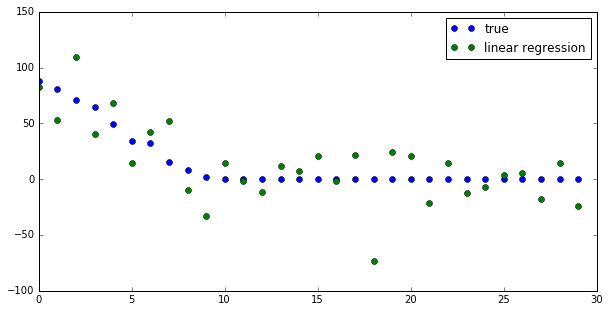

In [6]:
plt.figure(figsize=(10,5))
coefficient_sorting = np.argsort(true_coefficient)[::-1]
plt.plot(true_coefficient[coefficient_sorting], 'o', label='true')
plt.plot(linear_regression.coef_[coefficient_sorting], 'o', label='linear regression')

plt.legend()

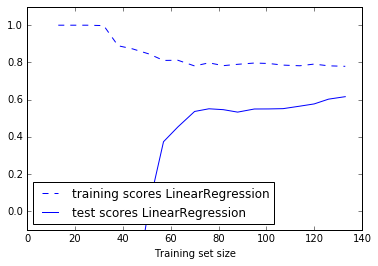

In [7]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(est, X, y,
                                                                 train_sizes=np.linspace(.1,1,20))
    estimator_name = est.__class__.__name__
    line = plt.plot(training_set_size, train_scores.mean(axis=1), '--',
                   label='training scores ' + estimator_name)
    plt.plot(training_set_size, test_scores.mean(axis=1), '-', label='test scores ' + estimator_name,
             c=line[0].get_color())
    plt.xlabel('Training set size')
    plt.legend(loc='best')
    plt.ylim(-0.1, 1.1)
    
plt.figure()
plot_learning_curve(LinearRegression(), X, y)

### Ridge Regression (L2 Penalty)

** The Ridge estimator** is a simple regularization (called l2 penalty) of the ordinary LinearRegression. 

$$min_{w,b} \Sigma_{i} || w^{T} x_{i} + b - y_{i} ||^{2} + \alpha || w ||_{2}^{2}$$

The amount of regularization is set via the `alpha` parameter of the Ridge.

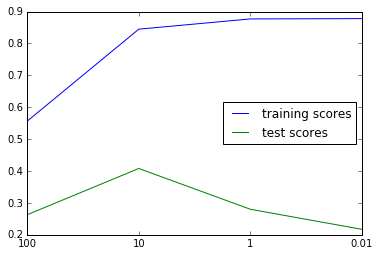

In [8]:
from sklearn.linear_model import Ridge
ridge_models = {}
training_scores = []
test_scores = []

for alpha in [100, 10, 1, .01]:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    training_scores.append(ridge.score(X_train, y_train))
    test_scores.append(ridge.score(X_test, y_test))
    ridge_models[alpha] = ridge

plt.figure()
plt.plot(training_scores, label='training scores')
plt.plot(test_scores, label='test scores')
plt.xticks(range(4), [100,10,1,.01])
plt.legend(loc='best')

### Lasso (L1 penalty)

**The Lasso estimator** is useful to impose sparsity on the coefficient. 
It would be prefered if we believe many of the features are not relevant.

$$min_{w,b} \Sigma_{i} || w^{T} x_{i} + b - y_{i} || ^{2} + \alpha || w ||_{1}$$

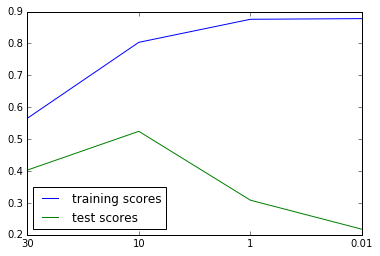

In [9]:
from sklearn.linear_model import Lasso

lasso_models = {}
training_scores = []
test_scores = []

for alpha in [30, 10, 1, .01]:
    lasso = Lasso(alpha=alpha).fit(X_train, y_train)
    training_scores.append(lasso.score(X_train, y_train))
    test_scores.append(lasso.score(X_test, y_test))
    lasso_models[alpha] = lasso
plt.figure()
plt.plot(training_scores, label='training scores')
plt.plot(test_scores, label='test scores')
plt.xticks(range(4), [30, 10, 1, .01])
plt.legend(loc='best')

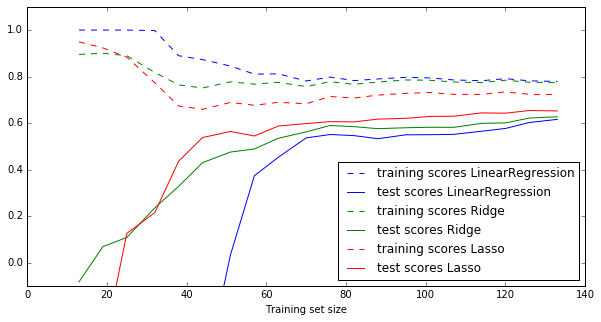

In [11]:
plt.figure(figsize=(10,5))
plot_learning_curve(LinearRegression(), X, y)
plot_learning_curve(Ridge(alpha=10), X, y)
plot_learning_curve(Lasso(alpha=10), X, y)

Instead of picking `Ridge` or `Lasso`, you can also use `ElasticNet`, which uses both forms of regularization and proves a parameter to assign a weighting between them. `ElasticNet` typically performs best among these models.

### Linear models for classification

All linear models for classification learn a coefficient parameter of `coef_` and an offset `intercept_` to make predictions using a linear combination of features:
~~~
y_pred = x_test[0] * coef_[0] +...+ x_test[n_features-1] * coef_[n_features-1] + intercept_ > 0
~~~
This is very similar to regression, but with a threshold at Zero.

The two most common models for linear classification are the linear SVM as implemented in LinearSVC and LogisticRegression.

### Influence of C in LinearSVC

In LinearSVC, the C parameter controls regularization within the model.

Lower C entails more regularization and simpler models, wheras higher C entails less regularization and more complex models.

In [16]:
# %load figures/plot_2d_separator.py
import numpy as np
import matplotlib.pyplot as plt

global plot_2d_separator
def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None):
    if eps is None:
        eps = X.std() / 2.
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]

    if ax is None:
        ax = plt.gca()
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, colors=['blue', 'red'])
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


#if __name__ == '__main__':
#    from sklearn.datasets import make_blobs
#    from sklearn.linear_model import LogisticRegression
#    X, y = make_blobs(centers=2, random_state=42)
#    clf = LogisticRegression().fit(X, y)
#    plot_2d_separator(clf, X, fill=True)
#    plt.scatter(X[:, 0], X[:, 1], c=y)
#    plt.show()

In [17]:
# %load figures/plot_linear_svc_regularization.py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
#from .plot_2d_separator import plot_2d_separator


def plot_linear_svc_regularization():
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    # a carefully hand-designed dataset lol
    y[7] = 0
    y[27] = 0

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    for ax, C in zip(axes, [1e-2, 1, 1e2]):
        ax.scatter(X[:, 0], X[:, 1], s=150, c=np.array(['red', 'blue'])[y])

        svm = SVC(kernel='linear', C=C).fit(X, y)
        plot_2d_separator(svm, X, ax=ax, eps=.5)
        ax.set_title("C = %f" % C)


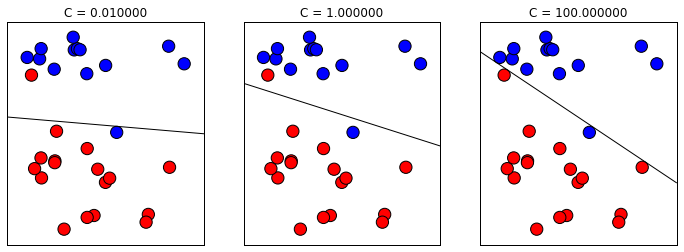

In [19]:
plot_linear_svc_regularization()

### Multi-Class linear classification

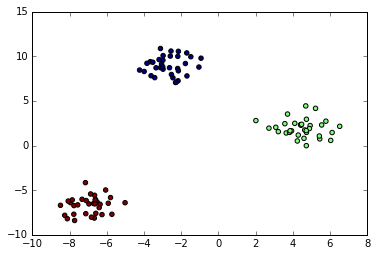

In [20]:
from sklearn.datasets import make_blobs
plt.figure()
X, y = make_blobs(random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y)

In [22]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X,y)
print(linear_svm.coef_.shape)
print(linear_svm.intercept_.shape)

(3L, 2L)
(3L,)


(-10, 8)

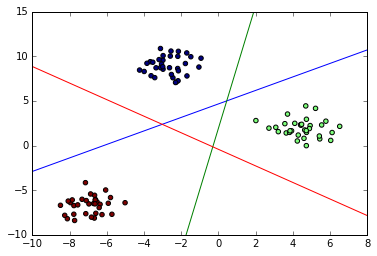

In [23]:
plt.scatter(X[:, 0], X[:, 1], c=y)
line = np.linspace(-15,15)
for coef, intercept in zip(linear_svm.coef_, linear_svm.intercept_):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1])
plt.ylim(-10,15)
plt.xlim(-10,8)